# Importing Libraries

In [21]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 6.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ac9ac23477bd133007aff84cf8f280ff678f495bb8c9fc17567ff3db85dbc0ed
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Importing Data

In [15]:
df = pd.read_csv('/content/drive/MyDrive/METABRIC_RNA_Mutation.csv', delimiter=',')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head()

There are 1904 rows and 693 columns


<ipython-input-15-b311b10989eb>:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/METABRIC_RNA_Mutation.csv', delimiter=',')


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


## Visualizing Data

In [17]:
f = 'pam50_+_claudin-low_subtype'
print( df[f].unique() )
df[f].value_counts()

['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'NC']


LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: pam50_+_claudin-low_subtype, dtype: int64

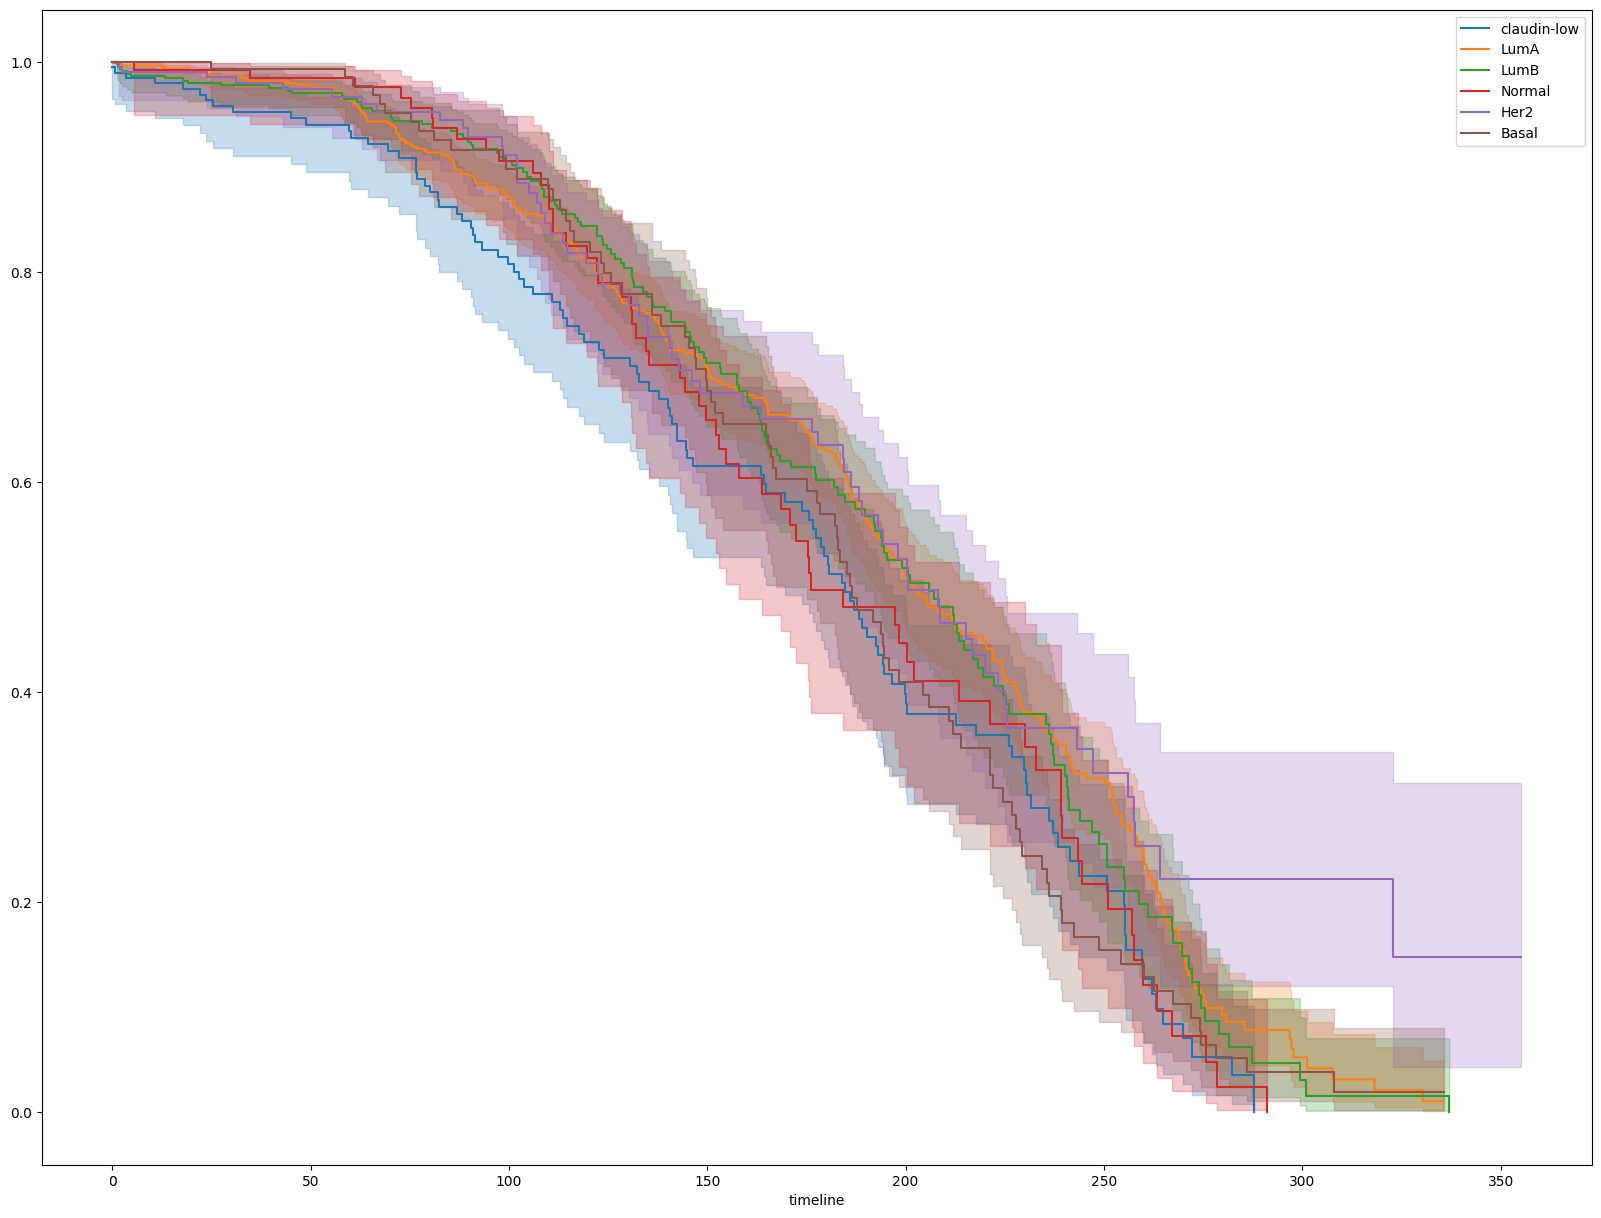

In [26]:
plt.figure(figsize = (20,15))
for v in ['claudin-low', 'LumA', 'LumB', 'Normal', 'Her2', 'Basal']:
    m = df[f] == v
    T = df['overall_survival_months'][m]
    E = df['overall_survival'][m]
    #T = df['Overall Survival (Months)'][m]
    #E =  df['Overall Survival Status'][m].map({'Living':1, 'Deceased':0} )
    kmf = KaplanMeierFitter(label=v)
    kmf.fit(T,E)
    kmf.plot()

<Axes: xlabel='timeline'>

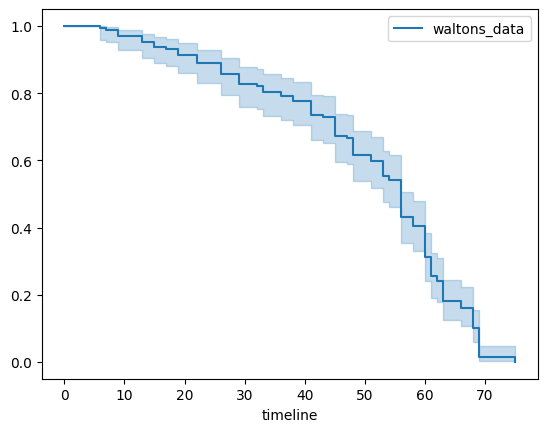

In [27]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons
waltons = load_waltons()

kmf = KaplanMeierFitter(label="waltons_data")
kmf.fit(waltons['T'], waltons['E'])
kmf.plot()

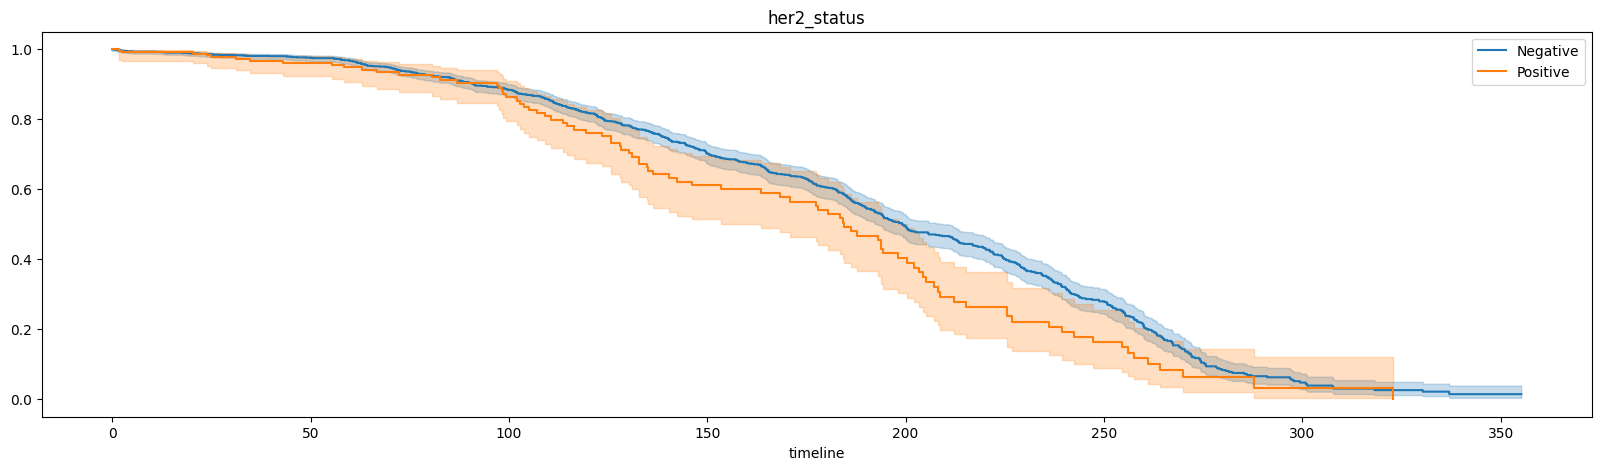

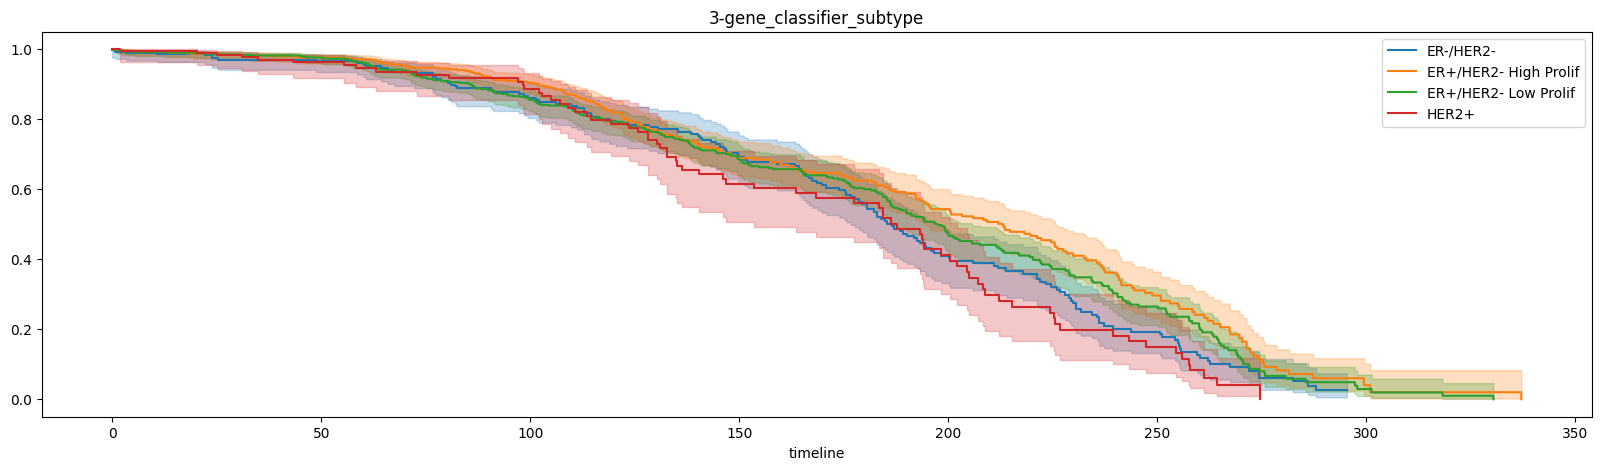

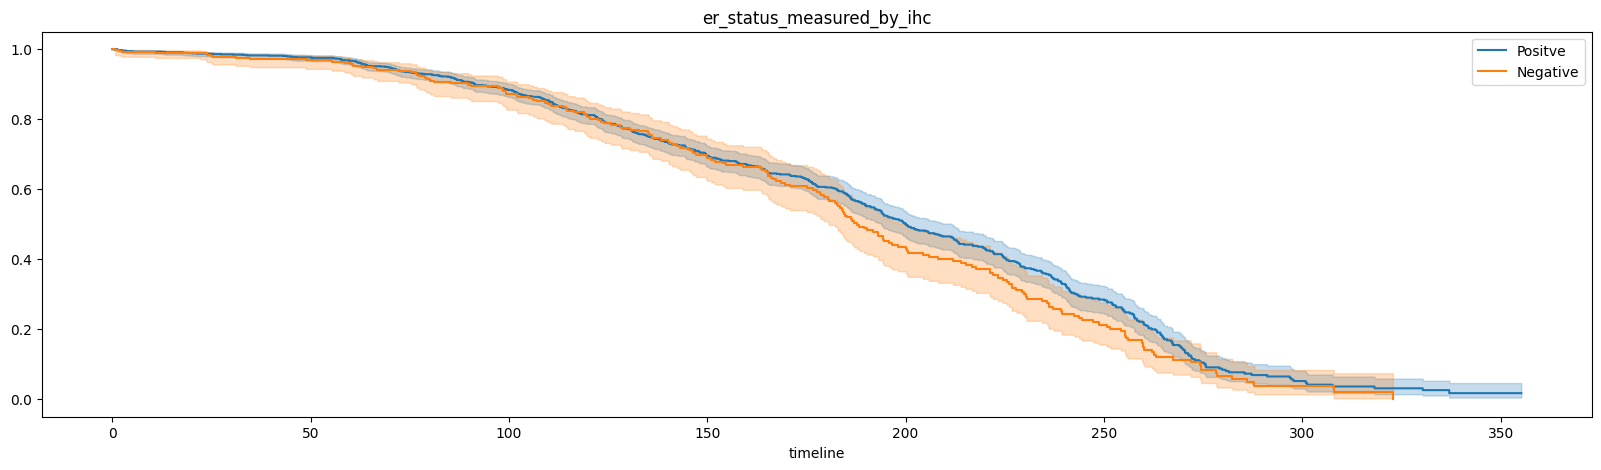

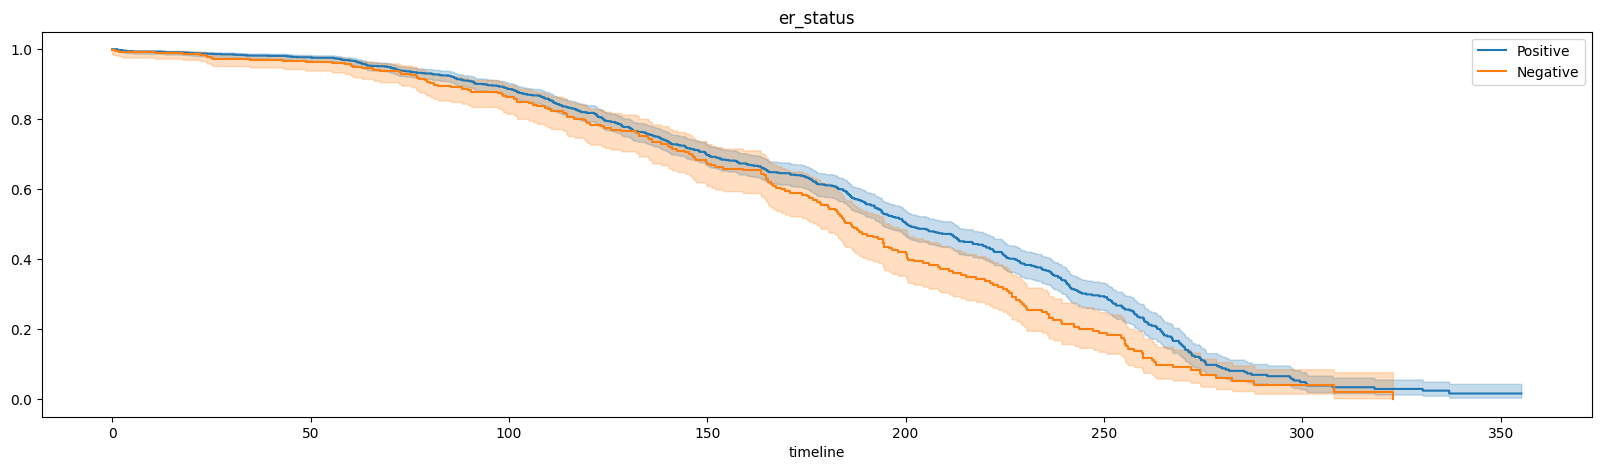

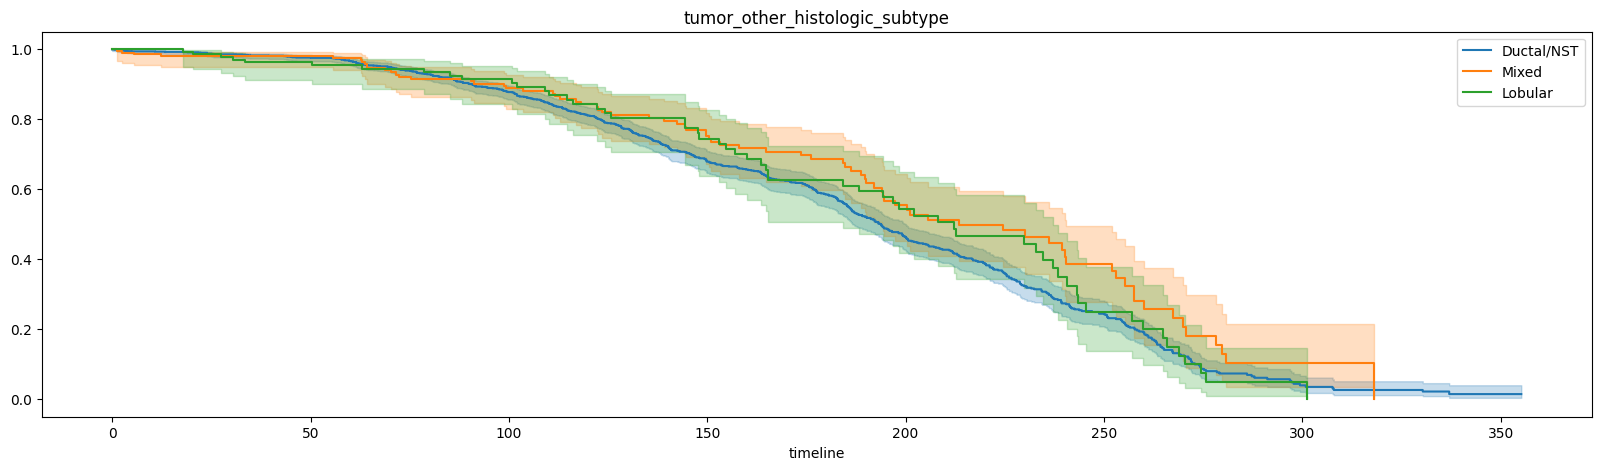

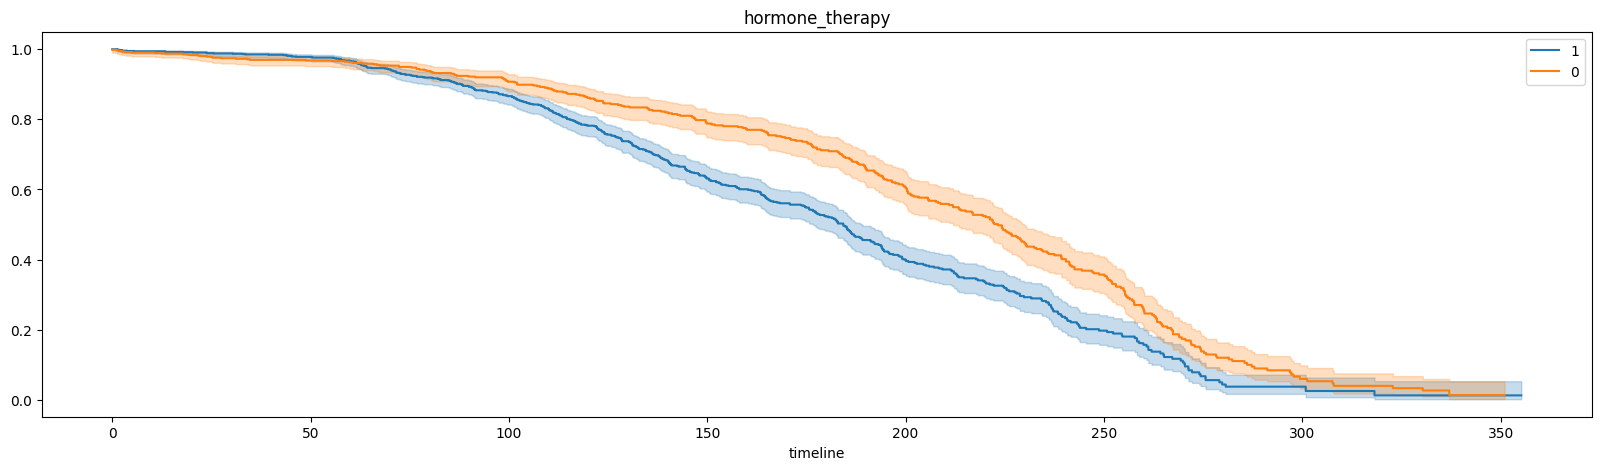

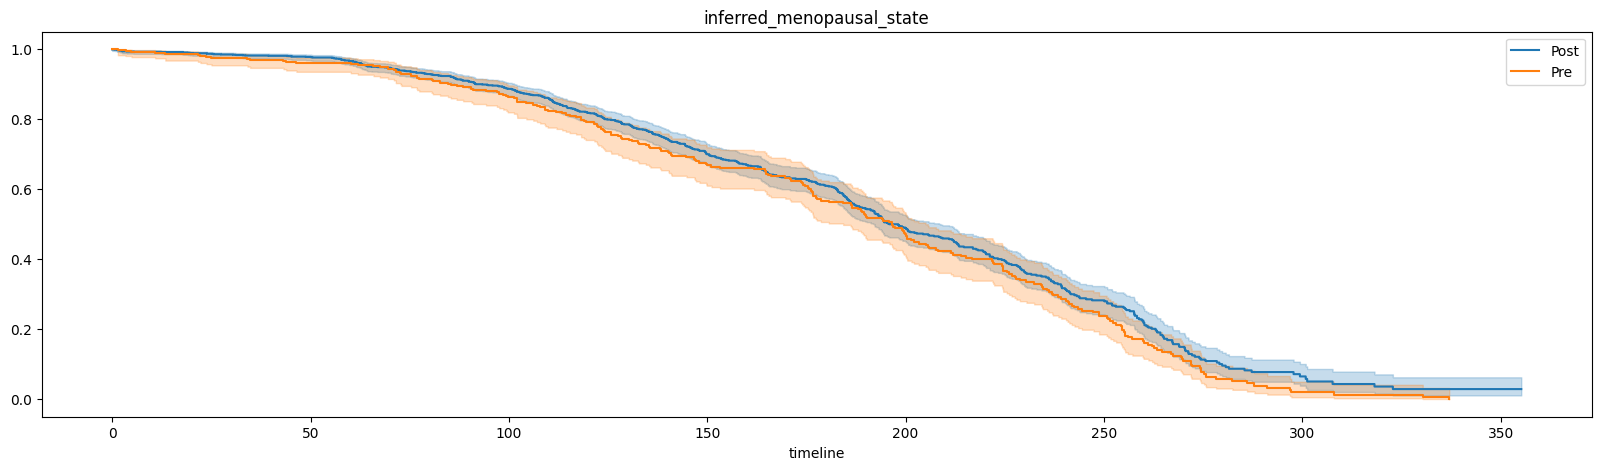

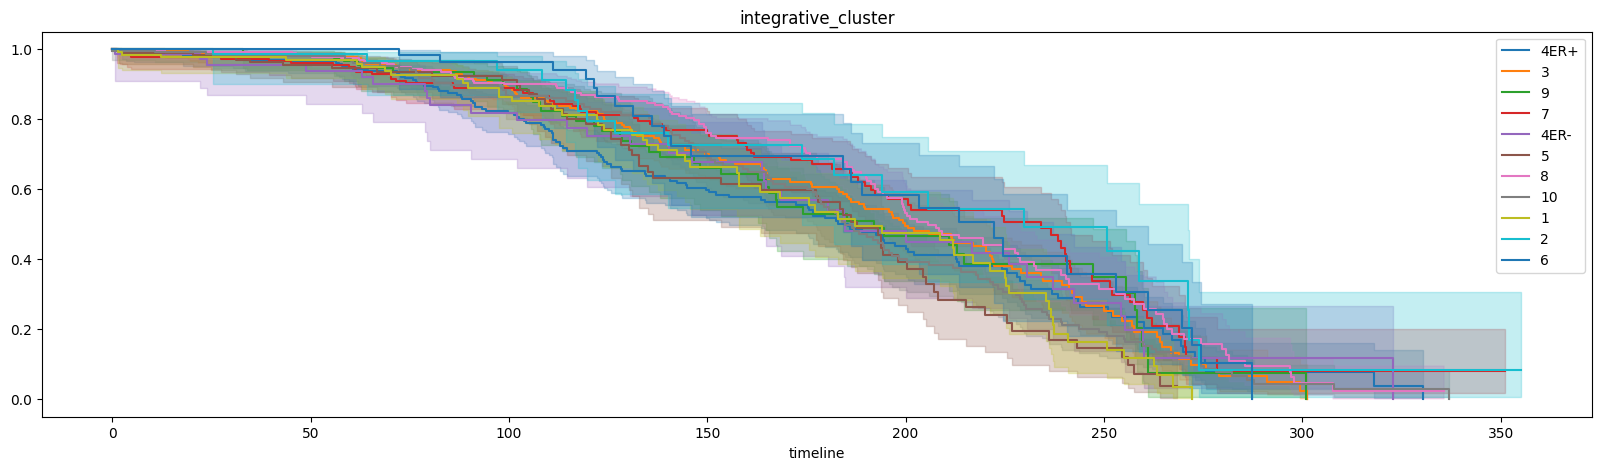

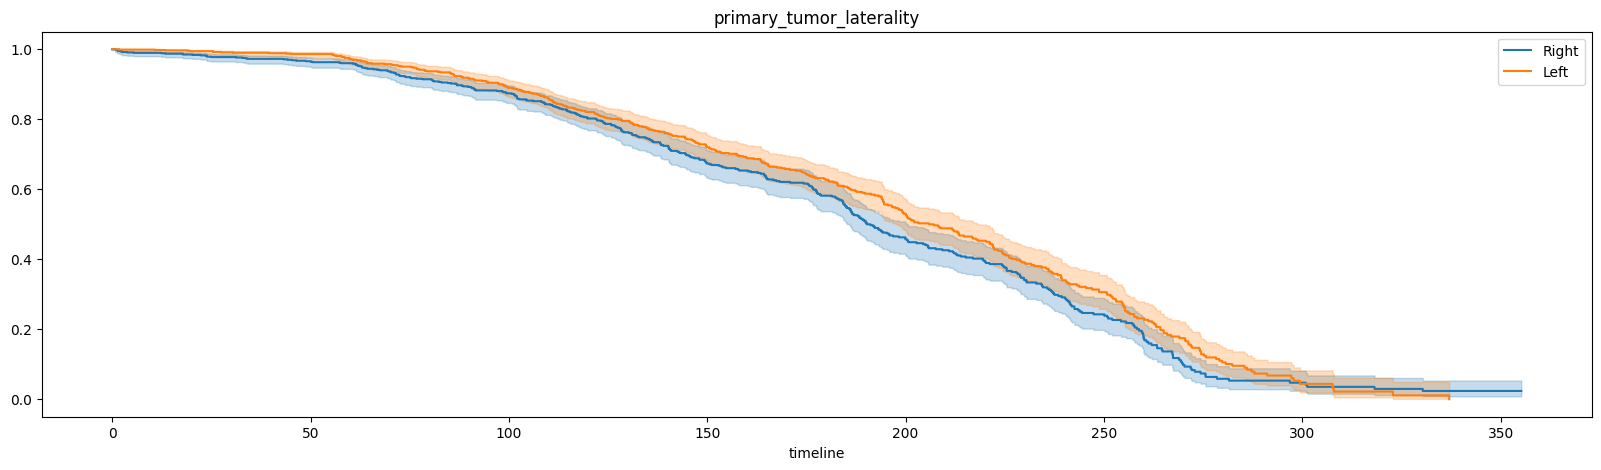

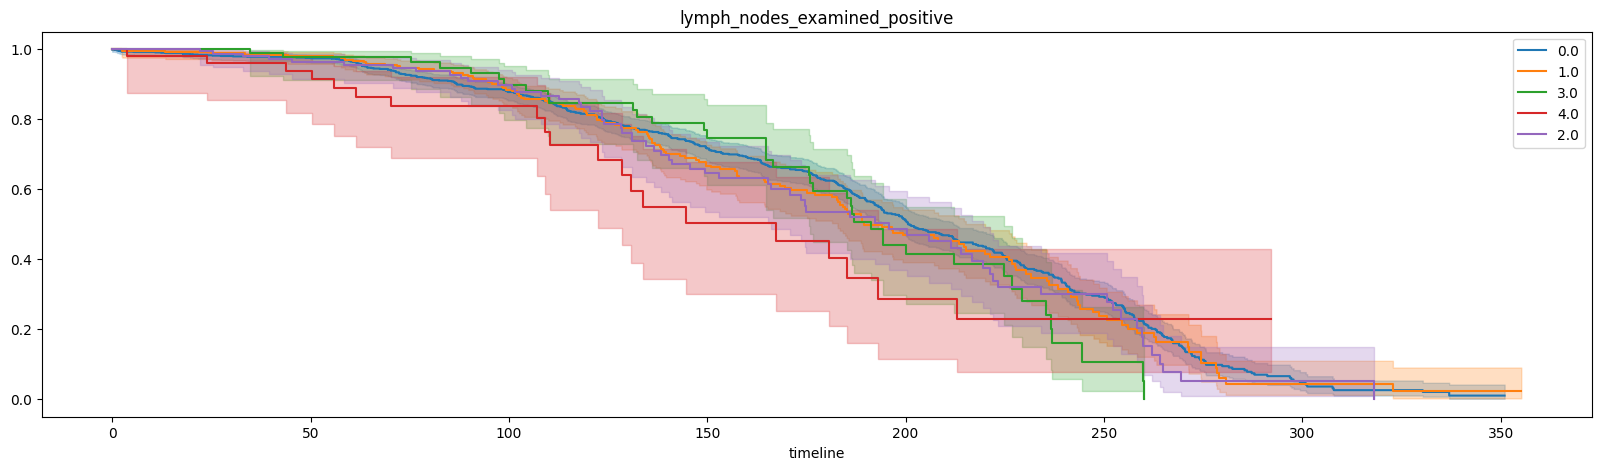

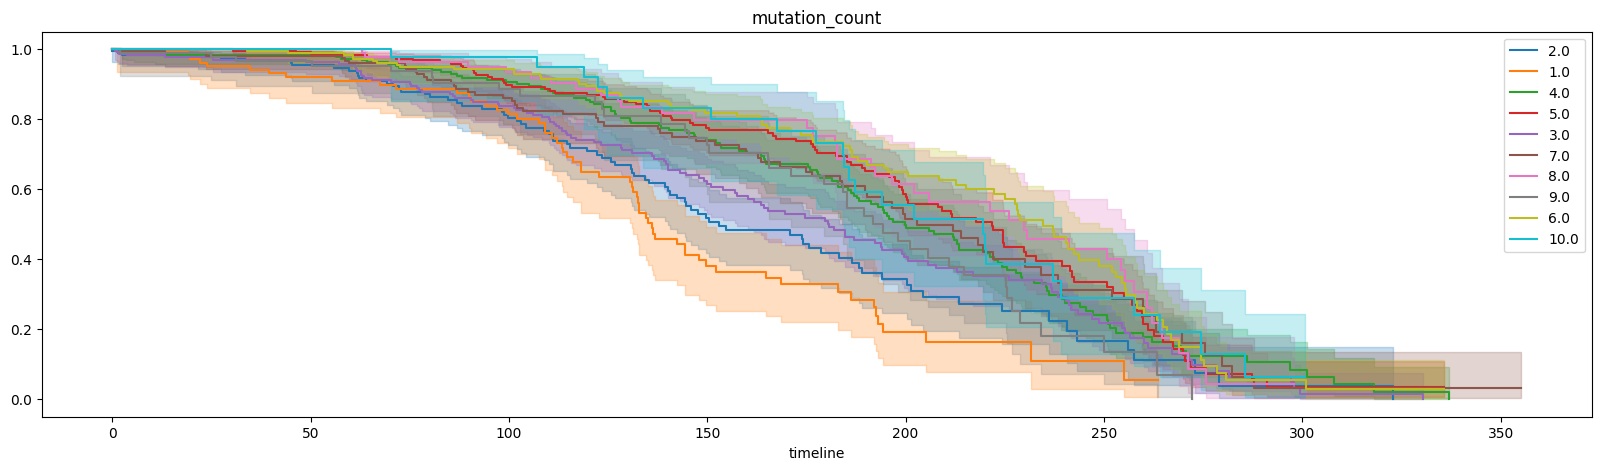

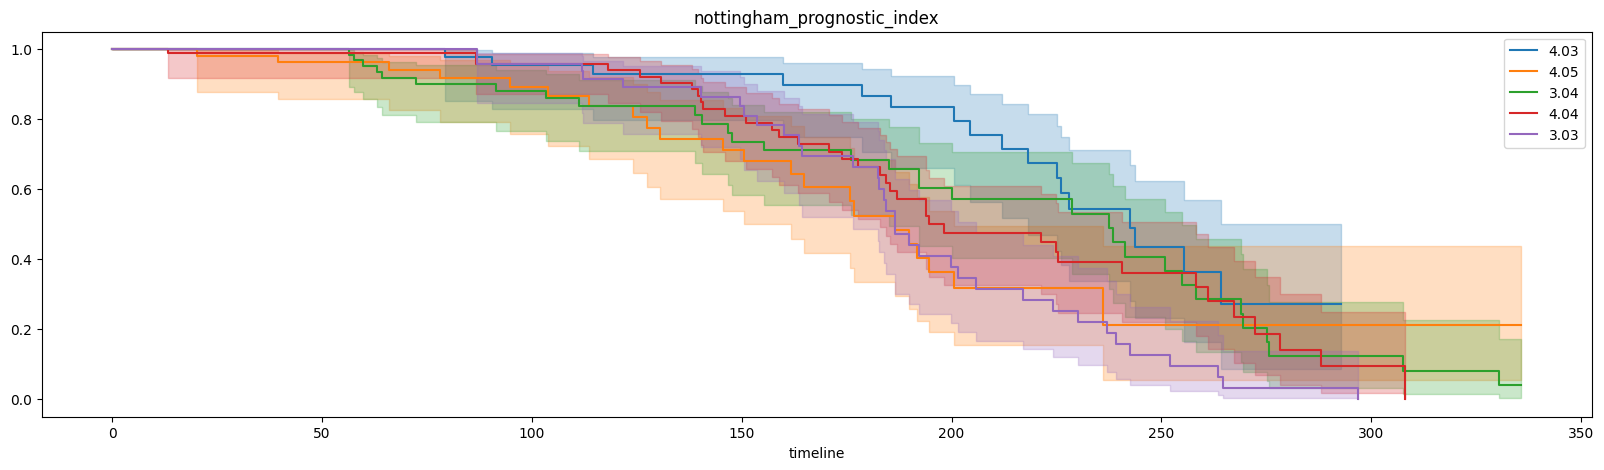

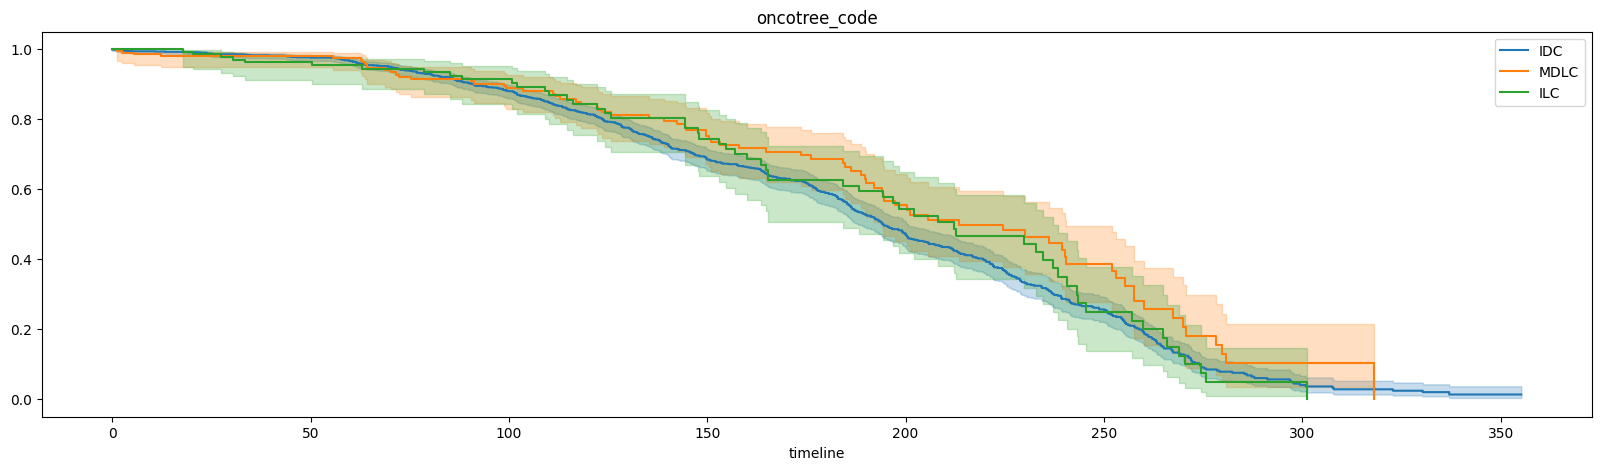

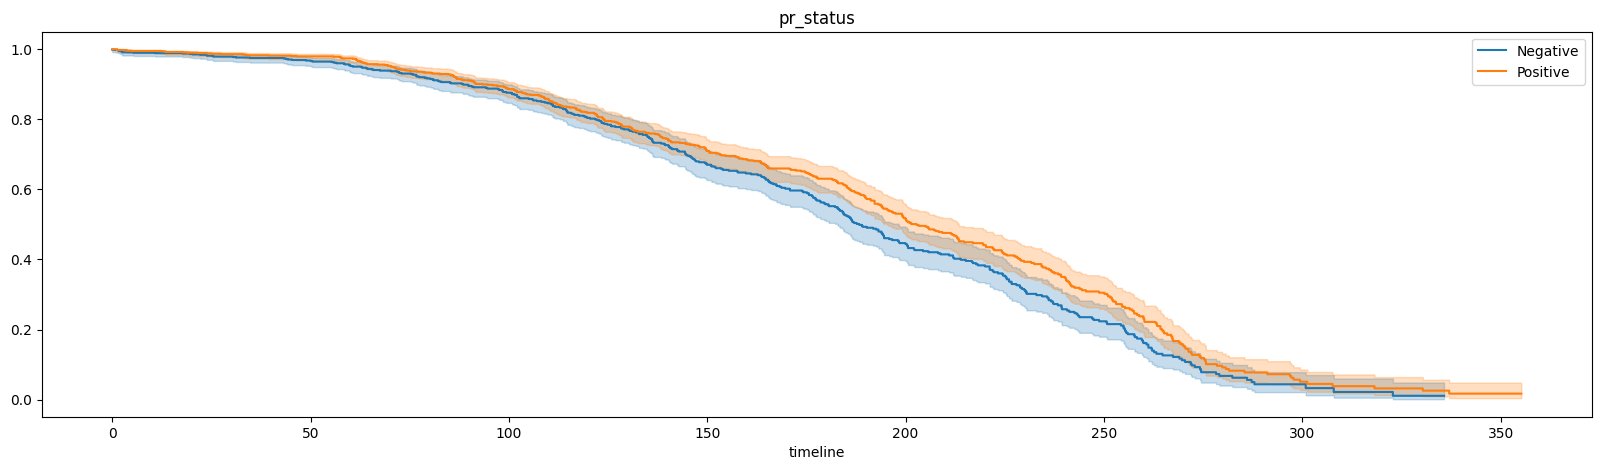

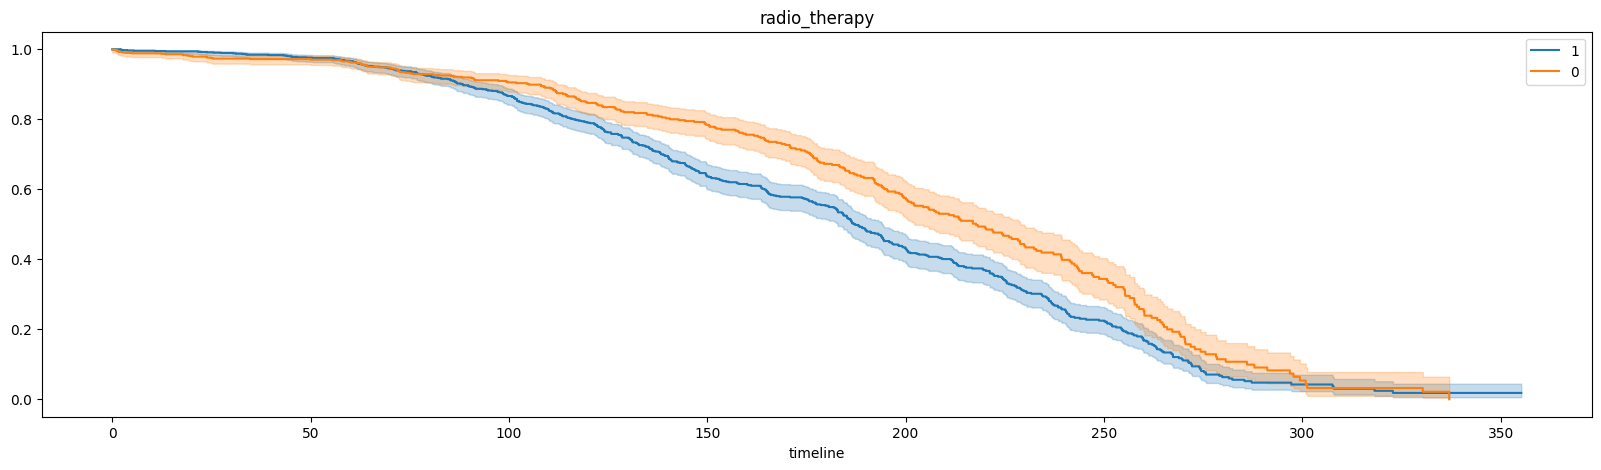

In [28]:
for c in ['her2_status', '3-gene_classifier_subtype', 'er_status_measured_by_ihc', 'er_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
        'pr_status',
       'radio_therapy',
         ]:
    plt.figure(figsize = (20,5))
    for v in df[c].unique(): #  ['claudin-low', 'LumA', 'LumB', 'Normal', 'Her2', 'Basal']:
        m = df[c] == v
        if m.sum() < 50: continue
        T = df['overall_survival_months'][m]
        E = df['overall_survival'][m]
        #T = df['Overall Survival (Months)'][m]
        #E =  df['Overall Survival Status'][m].map({'Living':1, 'Deceased':0} )
        kmf = KaplanMeierFitter(label=v)
        kmf.fit(T,E)
        kmf.plot()
        plt.title(c)

In [30]:
# We see that data are normalized - mean 0, std = 1
stat = df.iloc[:,32:].describe()
list_c = stat.columns
stat

,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,...,1904.0,1904.0,1904.0,1904.0,1904.0,1904.000000,1904.0,1904.000000,1904.0,1904.000000
mean,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,-4.726891e-07,...,1.0,1.0,1.0,1.0,1.0,0.462185,1.0,0.462185,1.0,0.462185
std,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,1.000263e+00,...,0.0,0.0,0.0,0.0,0.0,0.498699,0.0,0.498699,0.0,0.498699
min,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,-3.060200e+00,...,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000
25%,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,-6.838250e-01,...,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000
50%,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,-5.785000e-02,...,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000
75%,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,5.362750e-01,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000
max,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,4.850100e+00,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000


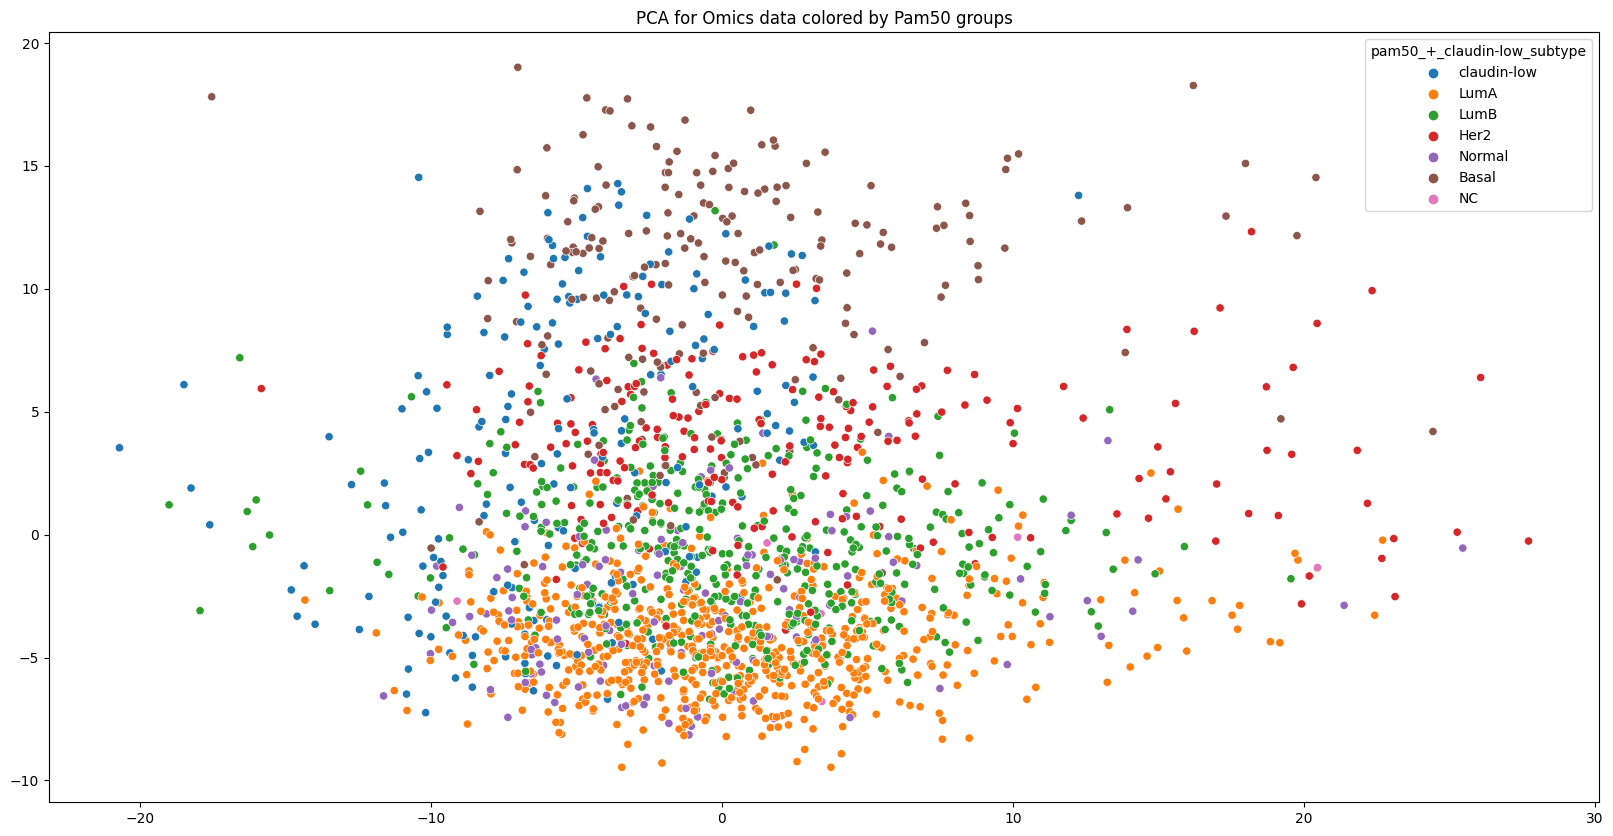

In [31]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA
r = pca().fit_transform(X = df[list_c].values)
f = 'pam50_+_claudin-low_subtype' # 'Pam50 + Claudin-low subtype'
plt.figure(figsize = (20,10))
sns.scatterplot( x=r[:,0], y=r[:,1], hue = df[f] )
plt.title('PCA for Omics data colored by Pam50 groups')
plt.show()

## Prediction

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Load your dataset into a pandas DataFrame and preprocess it.

# Split the data into features and target variables (X and y).
X = df.drop(columns=["patient_id", "overall_survival_months", "overall_survival"])
y = df["overall_survival"]

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical features
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(X_train[categorical_features])
X_test_categorical = encoder.transform(X_test[categorical_features])

# Standardize the numerical features
numerical_features = [col for col in X.columns if col not in categorical_features]
scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

# Combine the one-hot encoded categorical and standardized numerical features
X_train = np.hstack((X_train_categorical, X_train_numerical))
X_test = np.hstack((X_test_categorical, X_test_numerical))

# Define a deep learning model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
48/48 [==============================] - 2s 13ms/step - loss: nan - accuracy: 0.5712 - val_loss: nan - val_accuracy: 0.6142
Epoch 2/50
48/48 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 3/50
48/48 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 4/50
48/48 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 5/50
48/48 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 6/50
48/48 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 7/50
48/48 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5706 - val_loss: nan - val_accuracy: 0.6142
Epoch 8/50
48/48 [==============================] - 0s 5ms/st